In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

### Load dataset

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
parkinsons = fetch_ucirepo(id=174) 
  
# data (as pandas dataframes) 
X = parkinsons.data.features 
y = parkinsons.data.targets 
  
# metadata 
print(parkinsons.metadata) 
  
# variable information 
print(parkinsons.variables) 


{'uci_id': 174, 'name': 'Parkinsons', 'repository_url': 'https://archive.ics.uci.edu/dataset/174/parkinsons', 'data_url': 'https://archive.ics.uci.edu/static/public/174/data.csv', 'abstract': "Oxford Parkinson's Disease Detection Dataset", 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 197, 'num_features': 22, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['status'], 'index_col': ['name'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2007, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C59C74', 'creators': ['Max Little'], 'intro_paper': {'ID': 385, 'type': 'NATIVE', 'title': 'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection', 'authors': 'Max A. Little, P. McSharry, S. Roberts, D. Costello, I. Moroz', 'venue': 'BioMedical Engineering OnLine', 'year': 2007, 'journal': None, 'DOI': '10.1186/1475-925X-6-23', 'URL

In [5]:
path = "https://archive.ics.uci.edu/static/public/174/data.csv"
df = pd.read_csv(path)
df.head(200)

,name,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter,MDVP:Jitter.1,MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer.1,Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,phon_R01_S50_2,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,0.405,0.02336,0.02498,0.02745,0.07008,0.02764,19.517,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,phon_R01_S50_3,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,0.263,0.01604,0.01657,0.01879,0.04812,0.01810,19.147,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,phon_R01_S50_4,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,0.256,0.01268,0.01365,0.01667,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,phon_R01_S50_5,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,0.241,0.01265,0.01321,0.01588,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


### Data inspection

After loading and seeing the dataset, the first thing to notice are the differences between values of **PD** (at the top of the dataset) and of **normal people** (at the end of the dataset):

1) *Average vocal fundamental frequency* (MDVP:Fo) and *Maximum vocal fundamental f* (MDVP:Fhi) are much higher in normal people cause PD have difficulties into speech (more difficulties for laringeal muscles)

2) *Minimum vocal fundamental frequency* (MDVP:Flo) is lower in normal than in PD. This is quite variable and often in literature we see the opposite, the key thing is that there is a difference with normal.

3) Different measures of *variation in fundamental frequency* (MDVP:Jitter, Shimmer) are higher for PD than normal cause they can't keep a clean and costant neural potential like normal. 

The other features of the dataset are similar measurement and correlate with the ones just seen. We'll proceed with data exploration

In [6]:
print(f"Dataset shape: {df.shape}")
print(f"Dataset size: {df.size}")

print(df['status'].value_counts())

Dataset shape: (195, 24)
Dataset size: 4680
status
1    147
0     48
Name: count, dtype: int64


In [7]:
df.isnull().sum()

name              0
MDVP:Fo           0
MDVP:Fhi          0
MDVP:Flo          0
MDVP:Jitter       0
MDVP:Jitter.1     0
MDVP:RAP          0
MDVP:PPQ          0
Jitter:DDP        0
MDVP:Shimmer      0
MDVP:Shimmer.1    0
Shimmer:APQ3      0
Shimmer:APQ5      0
MDVP:APQ          0
Shimmer:DDA       0
NHR               0
HNR               0
status            0
RPDE              0
DFA               0
spread1           0
spread2           0
D2                0
PPE               0
dtype: int64

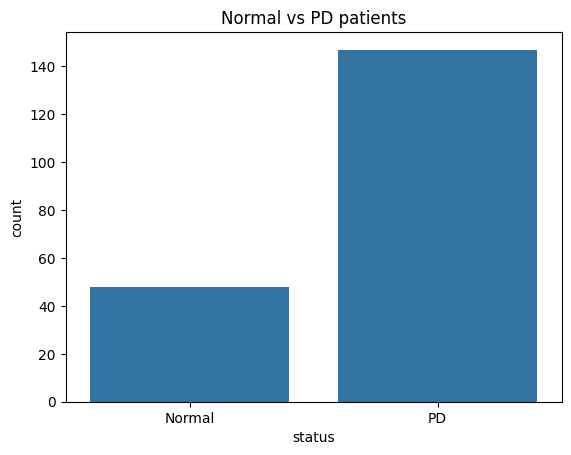

In [8]:
sns.countplot(data=df, x=df['status'])
plt.title("Normal vs PD patients")
plt.xticks(ticks=[0,1], labels=["Normal", "PD"])
plt.show()

Taking the 2 most important features (MDVP:Flo in x and MDVP:Fo in y) we notice a patient-specific correlation for those values and also that PD (status = 1) have lower values compared to normal. 

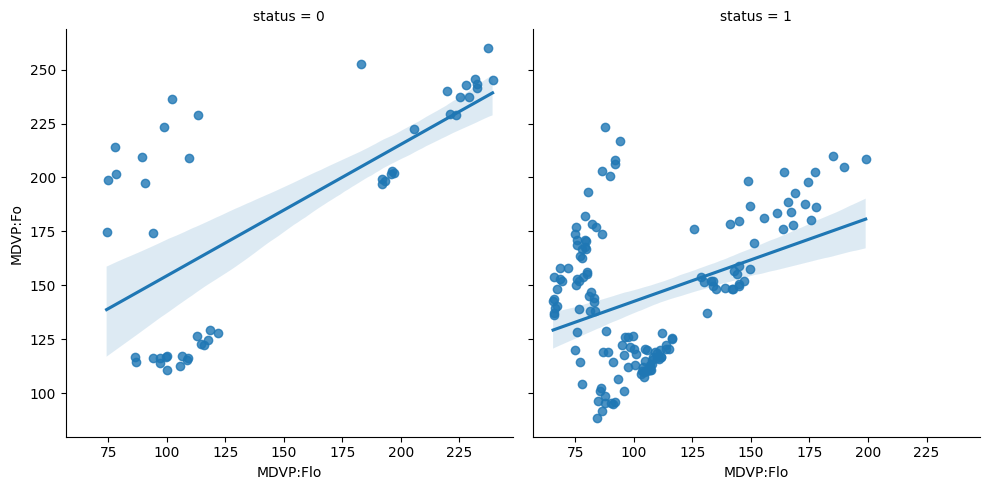

In [9]:
df_normal = df.query('status == 0')
df_PD = df.query('status == 1')

sns.lmplot(data=df, x='MDVP:Flo', y='MDVP:Fo', col='status')

### Data preprocessing and feature selection

Now I'll choose and inspect the best features for my ML model, remove target from dataset and split it into a training and a validation set.   

In [ ]:
df.nunique()

name              195
MDVP:Fo           195
MDVP:Fhi          195
MDVP:Flo          195
MDVP:Jitter       173
MDVP:Jitter.1      19
MDVP:RAP          155
MDVP:PPQ          165
Jitter:DDP        180
MDVP:Shimmer      188
MDVP:Shimmer.1    149
Shimmer:APQ3      184
Shimmer:APQ5      189
MDVP:APQ          189
Shimmer:DDA       189
NHR               185
HNR               195
status              2
RPDE              195
DFA               195
spread1           195
spread2           194
D2                195
PPE               195
dtype: int64

We can see that MDVP:Jitter.1 contains the less different values but we do not have to drop any here

In [32]:
# The goal here is to succesfully use χsquare or t-student to evaluate the power of feature 
# to use and create the algorithm, later use ROC or other way to inspect the accuracy
# of our model


#ok the first thing is to evaluate if the first 2 features seen have statistc significance
#instead of using t/test I'll use F classific cause it's more general and the only on scikit
X = df.drop(columns=['status', 'name'])
y = df['status']

selector = SelectKBest(score_func=f_classif, k=2).fit(X, y) #selecting best features

scores = pd.DataFrame({
    "Feature": X.columns,
    "F-score": selector.scores_,
    "p-value": selector.pvalues_
}).sort_values(by="F-score", ascending=False)
print(scores)

           Feature    F-score       p-value
18         spread1  90.424219  7.909651e-18
21             PPE  75.803195  1.392619e-15
19         spread2  50.343165  2.391729e-11
0          MDVP:Fo  33.286577  3.121919e-08
2         MDVP:Flo  32.612875  4.197004e-08
8     MDVP:Shimmer  30.122600  1.264702e-07
12        MDVP:APQ  29.536350  1.643238e-07
15             HNR  29.015927  2.074677e-07
11    Shimmer:APQ5  27.145033  4.823575e-07
9   MDVP:Shimmer.1  27.065484  5.000743e-07
10    Shimmer:APQ3  26.527120  6.386194e-07
13     Shimmer:DDA  26.525626  6.390539e-07
20              D2  25.265912  1.135925e-06
4    MDVP:Jitter.1  25.001729  1.282252e-06
16            RPDE  20.310049  1.139896e-05
6         MDVP:PPQ  17.548533  4.257767e-05
3      MDVP:Jitter  16.192809  8.209989e-05
5         MDVP:RAP  14.775226  1.643393e-04
7       Jitter:DDP  14.772666  1.645466e-04
17             DFA  10.952901  1.115116e-03
14             NHR   7.183270  7.994851e-03
1         MDVP:Fhi   5.478255  2

Ok we found more powerful features that the ones watched by eye, it seems those are the most significant. 
1) Spread 1/2: measures the spread of the signal and so the chaos in the measures of voice signal
2) Picth Period Entropy: indicator of unpredictability of the sound